# Airborne observations

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import product

import numpy as np
import xarray as xr
xr.set_options(display_style='text')

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

import cartopy.crs as ccrs
import seaborn as sns

import datasets
import figure_panels
import obs_aircraft
import util

## Load the aircraft data 

The data from the aircraft are returned as a `pandas.DataFrame`.

In [3]:
df = obs_aircraft.open_aircraft_data('obs')
df.head()

loading obs


,year,month,day,hour,min,sec,camp,flt,prof,lat,...,co2x,ch4noaa,co2mnoaa,co2noaa,co2mx,ch4mqcls,campaign_id,flight_id,profile_id,date
0,2009,1,9,20,25,20.0,1,2,1,45.83098,...,NaN,NaN,NaN,NaN,NaN,NaN,HIPPO-1,HIPPO-001-002,HIPPO-001-002-001,2009-01-09
1,2009,1,9,20,25,30.0,1,2,1,45.83351,...,NaN,NaN,NaN,NaN,NaN,NaN,HIPPO-1,HIPPO-001-002,HIPPO-001-002-001,2009-01-09
2,2009,1,9,20,25,40.0,1,2,1,45.83660,...,NaN,NaN,NaN,NaN,NaN,NaN,HIPPO-1,HIPPO-001-002,HIPPO-001-002-001,2009-01-09
3,2009,1,9,20,25,50.0,1,2,1,45.84057,...,NaN,NaN,NaN,NaN,NaN,NaN,HIPPO-1,HIPPO-001-002,HIPPO-001-002-001,2009-01-09
4,2009,1,9,20,26,0.0,1,2,1,45.84671,...,NaN,NaN,NaN,NaN,NaN,NaN,HIPPO-1,HIPPO-001-002,HIPPO-001-002-001,2009-01-09


## Campaign details

In [4]:
campaign_info = obs_aircraft.get_campaign_info(clobber=False, lump_orcas=True)

campaign_mon = [c['month'] for c in campaign_info.values()]
I = np.argsort([c['month'] for c in campaign_info.values()])

campaigns = np.array(list(campaign_info.keys()))[I]
time_bound = np.array([c['time_bound'] for c in campaign_info.values()])[I]

HIPPO-1:
	flights: ['HIPPO-001-006', 'HIPPO-001-007', 'HIPPO-001-008']
	time: 2009-01-20
	year: 2009
	month: 1
	day: 20
	time_bound: ['2009-01-19' '2009-01-24']
	co2_midtrop: 384.0980934046344
	ch4_midtrop: 1735.9877611940308
	sf6_midtrop: 6.44546875
	co2_midtrop_each_sensor: {'co2pfp': 383.83666666666664, 'co2medusa': 384.065, 'co2': 384.0980934046344, 'co2ao2': 384.0458322580646, 'co2oms': 384.4950883838382}
	co2_midtrop_multi_sensor: 384.1081361426408
	co2_midtrop_multi_sensor_std: 0.21413597118431896
HIPPO-2:
	flights: ['HIPPO-002-005', 'HIPPO-002-006', 'HIPPO-002-007']
	time: 2009-11-11
	year: 2009
	month: 11
	day: 11
	time_bound: ['2009-11-09' '2009-11-15']
	co2_midtrop: 385.4305322580645
	ch4_midtrop: 1762.1661757719726
	sf6_midtrop: 6.645344827586209
	co2_midtrop_each_sensor: {'co2pfp': 385.41, 'co2medusa': 385.39267000000007, 'co2': 385.4305322580645, 'co2ao2': 385.5355902061854, 'co2oms': 385.38648337595885}
	co2_midtrop_multi_sensor: 385.4310551680417
	co2_midtrop_multi_sens

## Flight tracks

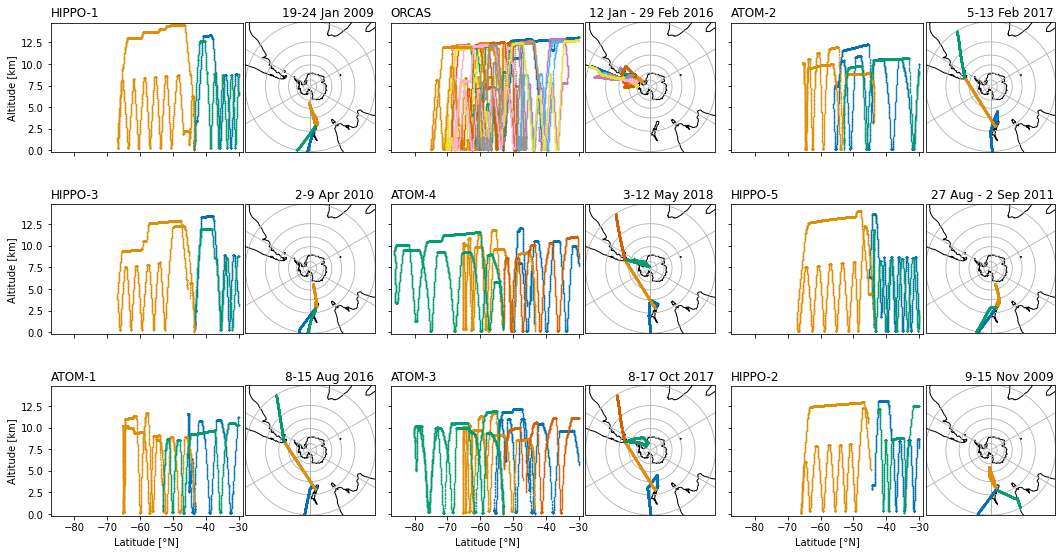

In [5]:
ncol = 3
nrow = 3

fig = plt.figure(figsize=(18, 10))

gs_outer = gridspec.GridSpec(
    nrows=nrow, ncols=ncol,
    wspace=0.05, hspace=0.01,
)

for c, (i, j) in enumerate(product(range(nrow), range(ncol))):
    gs_inner = gs_outer[i, j].subgridspec(1, 100, wspace=0.2)
    axMap = fig.add_subplot(gs_inner[0, 60:], projection=ccrs.Gnomonic(central_latitude=-90.0, central_longitude=0.0)) #ccrs.SouthPolarStereo())
    axSex = fig.add_subplot(gs_inner[0, :60])
    
    axMap.coastlines('110m')
    axMap.set_extent([180, -180, -90,  -30], crs=ccrs.PlateCarree())
    axMap.gridlines()
    
    
    df_sub = obs_aircraft.groups_get_dataframe(df, campaigns[c], lump_orcas=True)
    fight_ids = list(df_sub.flight_id.unique())
    datestr = obs_aircraft.campaign_datestr(time_bound[c])
    
    palette_colors = sns.color_palette(figure_panels.sns_palette, len(fight_ids)).as_hex()
        
    for n, flight_id in enumerate(fight_ids):
        df_sub_sub = df_sub.loc[df_sub.flight_id == flight_id]
        axMap.plot(
            df_sub_sub.lon, df_sub_sub.lat, 
            '.',
            markersize=1,
            color=palette_colors[n],
            transform=ccrs.PlateCarree(),
        )

        axSex.plot(
            df_sub_sub.lat, df_sub_sub.alt*1e-3, 
            '.', 
            markersize=1,            
            color=palette_colors[n],                   
        )
        
        axSex.set_ylim((-0.2, 14.8))
        axSex.set_xlim(-87.25, -28.75)
        
        
        if j == 0:
            axSex.set_ylabel('Altitude [km]')
        else:
            axSex.set_yticklabels([])
        
        if i == nrow - 1:
            axSex.set_xlabel('Latitude [°N]')
        else:
            axSex.set_xticklabels([])
    
    axSex.set_title(campaigns[c], loc='left')
    axSex.set_title(datestr, x=1.68, ha='right')
    
    l, b, w, h = axSex.get_position().bounds
    axSex.set_position([l, b+0.034, w*0.99, h*0.72])

util.savefig('flight-tracks') 

## Meridional CO<sub>2</sub> sections

### Load latitude-altitude bin-averaged dataset

In [6]:
ds = datasets.aircraft_sections()
ds

<xarray.Dataset>
Dimensions:       (z: 22, y: 20, time: 9, ye: 20, ze: 23)
Coordinates:
    ALT           (z, y) float64 0.25 0.25 0.25 0.25 ... 10.75 10.75 10.75 10.75
    LAT           (z, y) float64 -78.75 -76.25 -73.75 ... -36.25 -33.75 -31.25
    campaigns     (time) <U7 'HIPPO-1' 'HIPPO-2' 'HIPPO-3' ... 'ATOM-3' 'ATOM-4'
    month         (time) int64 1 11 4 8 2 8 2 10 5
  * time          (time) datetime64[ns] 2009-01-20 2009-11-11 ... 2018-05-07
  * y             (y) float64 -78.75 -76.25 -73.75 ... -36.25 -33.75 -31.25
  * ye            (ye) float64 -80.0 -77.5 -75.0 -72.5 ... -37.5 -35.0 -32.5
    year          (time) int64 2009 2009 2010 2011 2016 2016 2017 2017 2018
  * z             (z) float64 0.25 0.75 1.25 1.75 2.25 ... 9.25 9.75 10.25 10.75
  * ze            (ze) float64 0.0 0.5 1.0 1.5 2.0 ... 9.0 9.5 10.0 10.5 11.0
Data variables:
    CO2_binned    (time, z, y) float64 nan nan nan nan ... 405.9 405.8 405.5
    DCO2_binned   (time, z, y) float64 nan nan nan nan ... 1.151 1.029 0.7226
    N_CO2         (time, z, y) float64 nan nan nan nan ... 56.0 209.0 252.0 66.0
    N_DCO2        (time, z, y) float64 nan nan nan nan ... 56.0 209.0 252.0 66.0
    THETA         (time, z, y) float64 nan nan nan nan ... 327.8 336.2 336.9
    THETA_binned  (time, z, y) float64 nan nan nan nan ... 327.3 336.5 337.4

### Visualize sections

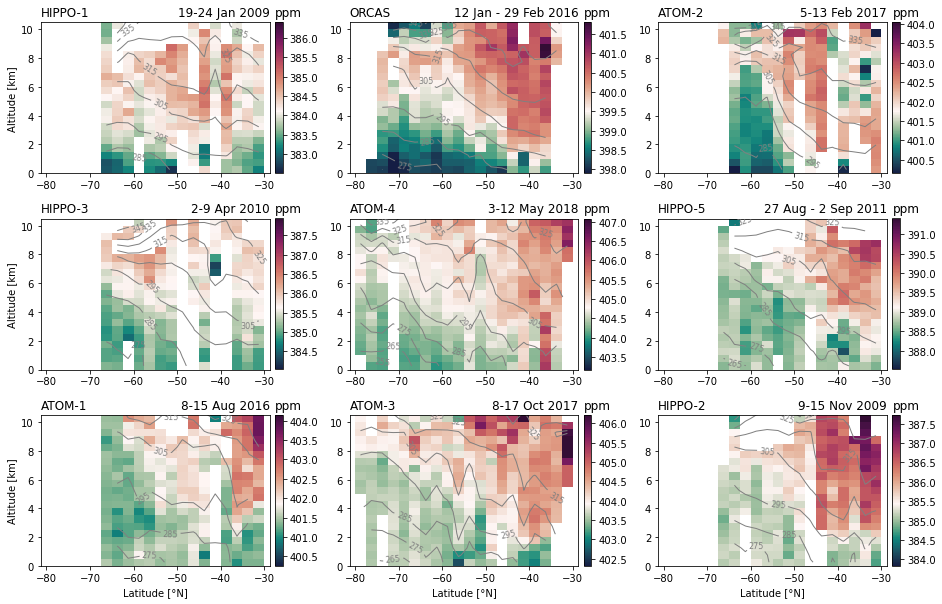

In [7]:
fig, axs = util.canvas(3, 3, 
                       figsize=(16/3, 10/3), 
                       use_gridspec=True, 
                       hspace=0.3, wspace=0.12,
                       width_ratios=[1, 1, 1,],
                      )

for n, i in enumerate(np.argsort(ds.month.values)):
    ax = axs[np.unravel_index(n, (3, 3))]
    
    if not np.isnan(ds.DCO2_binned.isel(time=i)).all():
        co2_ref = campaign_info[ds.campaigns.values[i]]['co2_midtrop_multi_sensor']
        
        vmin, vmax = np.array(figure_panels.co2_anom_bounds) + co2_ref
        divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=co2_ref, vmax=vmax)  
        cf = ax.pcolormesh(
            ds.y, ds.z, ds.CO2_binned.isel(time=i),
            norm=divnorm,
            cmap=figure_panels.cmap,
            shading='nearest',
        )
        cs = ax.contour(
            ds.LAT, ds.ALT, ds.THETA.isel(time=i),
            levels=np.arange(255., 350., 10.),
            linewidths=1,
            colors='gray')    
        lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%d')    
        
        cb = plt.colorbar(cf, ax=ax, pad=0.02)
        cb.ax.set_title('ppm', loc='left')
        
    tb = campaign_info[ds.campaigns.values[i]]['time_bound']    
    
    date_str = obs_aircraft.campaign_datestr(tb)
    
    ax.set_title(date_str, loc='right')
    ax.set_title(ds.campaigns.values[i], loc='left')
    ax.set_ylim((0, 10.5))
    ax.set_xlim(-81.25, -28.75)

    if n%ncol == 0:
            ax.set_ylabel('Altitude [km]')

    if n >= (nrow-1) * ncol:
        ax.set_xlabel('Latitude [°N]')

util.savefig(f'aircraft-sections')